## Tutorial 3  - Deconvolution

Authors:
Romain JL Fétick, Alexis Lau

This notebook is designed to run in either Google Colab, or locally in your machine (need to install packages). 

#### **Table of contents**
This tutorial will cover the following topics: 
1. Image formation
2. Wiener filtering 
3. MAP deconvolution

#### **Introduction**
Deconvolution is cruciaal for enhancing image quality by reversing the effects of distortion and blurring, which often occur due to factors like system limitations, atmospheric turbulence, motion blur, or optical imperfections. In real-world scenarios, the captured image may not accurately represent the true object, but deconvolution helps restore a clearer and more precise version of the original image.

In astrophysics, deconvolution plays a key role in extracting valuable information from images of celestial objects. It aims to restore the high spatial frequencies lost due to distortions, allowing for more detailed analysis. 

In [2]:
import numpy as np
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage.filters import convolve, convolve1d, gaussian_filter
import math
from scipy import fftpack
import sys

from scipy.signal import fftconvolve
from numpy.fft import fft2, fftshift, ifft2, ifftshift
import matplotlib.pyplot as plt
from scipy.optimize import fmin_l_bfgs_b
from scipy.ndimage import gaussian_filter


/var/folders/6l/77hlnn39583fpv6dzlxy8lj00000gn/T/ipykernel_84572/3843730120.py:5: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve, convolve1d, gaussian_filter
/var/folders/6l/77hlnn39583fpv6dzlxy8lj00000gn/T/ipykernel_84572/3843730120.py:5: DeprecationWarning: Please use `convolve1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve, convolve1d, gaussian_filter
/var/folders/6l/77hlnn39583fpv6dzlxy8lj00000gn/T/ipykernel_84572/3843730120.py:5: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve, convolve1d, gaussian_filter


#### TODO - write instruction to setup google drive directory, also where to get the data

In [3]:
# !pip install git+https://github.com/ArcetriAdaptiveOptics/OAO24.git
# from oao24 import package_data

# dark_image = np.load(package_data.tuto3_folder() / "ID_110.npy")
# open_loop_image = np.load(package_data.tuto3_folder() / "ID_105.npy")

In [4]:
# seeing_limited_ima = open_loop_image-dark_image
# ima = np.clip(seeing_limited_ima, 0, np.inf)
# plt.imshow(ima)
# plt.colorbar()

<!-- ## Deconvolution
1. Create an image with objects and PSFs provided
   1. Objects: Vesta, Ganymede (to be determined) 
   2. PSFs: Papyrus-liked PSFs 
2. Using Wiener Filtering to deconvolve an image 
   1. Equations for the noise estimation will be provided in the notebook 
3. MAP 
   1. Try to build your own MAP -->


#### **1 - Image formation**

Before starting work on deconvolution, it is essential to first understand how an image is formed. Assuming the noise is purely additive, any 2D image can be characterised by its intensity distribution $I$: 

\begin{equation}
I = H * O + N
\end{equation}



where $I$ is the image, $H$ is the Point Spread Function (PSF), $O$ is the object, and $N$ represents the additive noise.

Below are some helper functions to carry out certain tasks.

In [17]:
def fft(tab):
    """Centered FFT"""
    return fftshift(fft2(fftshift(tab)))

def ifft_real(tab):
    """Centered iFFT, force result to be real"""
    return np.real(ifftshift(ifft2(ifftshift(tab))))

If in doubt, you can always use ? to find out how the function works. Below is an example

In [18]:
fft?

Signature: fft(tab)
Docstring: Centered FFT
File:      /var/folders/6l/77hlnn39583fpv6dzlxy8lj00000gn/T/ipykernel_84572/2223466896.py
Type:      function

In [12]:
# Parameter to modify
path = '/Users/ylau/Desktop/deconvolution_tutorial/'
flux = 4e7
ron = 4
photon_noise = True

Here you will load the files to create the image. The PSF and the object are loaded into .fits format, which would require astropy to open it. 

In [13]:
fts = fits.open(path+'psf_high_sr.fits')
psf = fts[0].data
fts.close()

fts = fits.open(path+'vesta.fits')
vesta = fts[0].data
fts.close()

Create an image with a given flux 

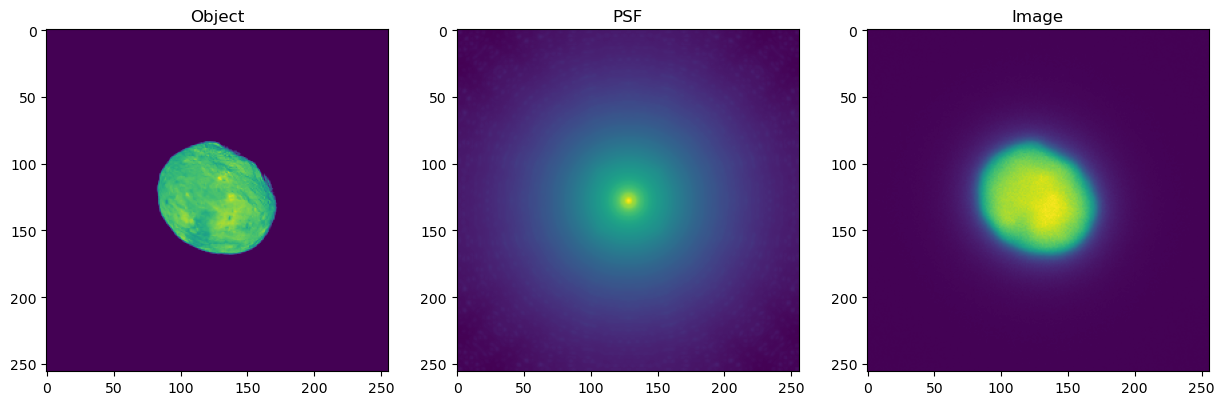

In [22]:
vesta = flux*vesta/np.sum(vesta)

nx = vesta.shape[0]

noise_ron = ron*np.random.randn(nx,nx) # Gaussian noise 
convolution = ifft_real(fft(vesta)*fft(psf))

if photon_noise:
    image = np.random.poisson(convolution) + noise_ron
else:
    image = convolution + noise_ron


# Plot the image
fig, axes = plt.subplots(1,3, figsize=(15,5))

axes[0].set_title('Object')
axes[0].imshow(vesta,,cmap='gray')

axes[1].set_title('PSF')
axes[1].imshow(np.log(psf) ,cmap='gray')

axes[2].set_title('Image')
axes[2].imshow(image, ,cmap='gray')


**Task**: How does the image look like when we only have gaussian noise? Try setting the photon_noise = False to find out. 


#### **2 - Wiener filtering**


$$
\hat{w}_k = \frac{\hat{h}_k^*}{|\hat{h}_k|^2 + \frac{E\{| \hat{n}_k |^2\}}{E\{| \hat{x}_k |^2\}}}
$$


This equation represents the Wiener filtering process in a communication or signal processing context, where the goal is to estimate the original signal $\hat{x}_{W,k}$ from a noisy observation $ \hat{y}  $. Here's a breakdown of the components:

Equation Breakdown:

- $\hat{w}_k$ represents the **Wiener filter** at frequency index \(k\), which is a function of the signal and noise power spectra. This coefficient is applied to the noisy observation $\hat{y}$ to produce the filtered estimate.

- $ \hat{h}_k $ represents the Fourier transform of the PSF (**OTF**) at index \(k\). 

- $ \hat{n}_k $ represents the Fourier transform of **noise** in the system at frequency index \(k\), with $ E\left\{ |\hat{n}_k|^2 \right\} $ being its expected power.

- $ \hat{x}_k $ is the Fourier transform of **original signal** at frequency index \(k\), and $ E\left\{ |\hat{x}_k|^2 \right\} $ represents its expected power.

Now you have an image which includes the noise and PSF. It's time to start thinking about how to deblur the image. Wiener filtering makes assumption about the noise (Gaussian, stationary) while astronomical images often dominated by photon noise. Also, we need model to estimate the PSD of both the object and the noise. 

**Task**: From the equation above, try to build wiener filter function.

*Hint*: you need to estimate the noise of the image, and a PSD model as a prior for the wiener filtering. Below there are some helper functions. 


In [1]:
def estimate_noise_std(image, psf):
    """Estimate the noise standard deviation of an image"""
    image_tf = fft(image)
    mtf = np.abs(fft(psf))
    msk_outside = mtf < 1e-6
    noise_var = np.mean(np.abs(image_tf[msk_outside])**2) / nx**2
    return np.sqrt(noise_var)

def estimate_ron(image, psf, photon_noise=False):
    """Estimate the RON from an image"""
    noise_var = estimate_noise_std(image, psf)**2
    photon_var = min(np.mean(image), noise_var) # min() avoid issue in sqrt
    ron_std = np.sqrt(noise_var - photon_noise*photon_var)
    return ron_std

def psd_model(nx, flux, pix_size):
    """
    Model of an object PSD as:
        PSF(f) = flux²/(1+(f/f_cut)^3)
    """
    xx,yy = np.mgrid[0:nx,0:nx] - nx//2
    rr = np.sqrt(xx**2+yy**2)
    rho = nx/pix_size/2
    return flux**2/(1+(rr/rho)**3)

In [20]:
# Fourier transforms of various input for data analysis later
otf = fftshift(fft2(fftshift(psf)))
ft_image = fftshift(fft2(fftshift(image)))
ft_vesta = fftshift(fft2(fftshift(vesta)))
ft_noise = fftshift(fft2(fftshift(noise_ron)))

In [ ]:
# Plot your results here!
fig, ax = plt.subplots(1,3)
ax[0].set_title('Object')
ax[0].imshow(vesta, cmap='gray')

ax[1].set_title('Image')
ax[1].imshow(image, cmap='gray')

ax[2].set_title('Wiener filtering')
ax[2].imshow(deconv_wiener, cmap='gray')

#### **3 - Maximum A Posteriori**
The Maximum A Posteriori (MAP) is used to restore an image or signal that has been degraded by blurring and noise. MAP is rooted in Bayesian estimation and provides a probabilistic framework to recover the original image by maximizing the posterior probability.


MAP aims to estimate the most likely original object (or image) $O$ given the observed image $I$, based on prior knowledge about the image and the noise. It seeks the estimate object that maximizes the posterior probability:

$$
\mathbf{x}_{\text{MAP}} = \arg\min_{\mathbf{x}} \left\{ \frac{1}{2} \| \mathbf{y} - H \mathbf{x} \|_{C_n^{-1}}^2 - \log P(\mathbf{x}) \right\}
$$




**Task** (See in the `__call__ `in the class `MAPcriterion`): 
- Code your own function for the map criterion 
- Code the associated gradient function 

Some helper functions for building the MAP criterion

In [23]:
def likelihood(image, obj, psf, weights):
    """
    Compute the likelihood such as:
        L=||weights*(img-obj⨂psf)||²
    where `weights` is the inverse of the noise variance.
    """
    obj_tf = fft(obj)
    otf = fft(psf)
    conv = ifft_real(obj_tf*otf)
    fun = np.sum(weights*(image-conv)**2.0) / 2.0
    grad = -fft(weights*(image-conv)) * np.conjugate(otf)
    grad = ifft_real(grad)
    return fun, grad

def regularization_quadratic(obj):
    """
    Compute a regularization term of the form:
        R=||𝛁x||²+||𝛁y||²
    """
    dx = obj - np.roll(obj,1,axis=0)
    dy = obj - np.roll(obj,1,axis=1)
    fun = np.sum(dx**2+dy**2)
    grad = dx - np.roll(dx,-1,axis=0) + dy - np.roll(dy,-1,axis=1)
    return fun, grad

In [24]:
class MAPcriterion:
    def __init__(self, image, psf, photon_noise=False):
        self.iteration = 0
        self.criterion = 0

        self.image = image
        self.psf = psf

        image_smooth = gaussian_filter(image, 1)
        ron_estim = estimate_ron(image, psf, photon_noise=photon_noise)
        self.weights = 1/(image_smooth*photon_noise+ron_estim**2)

        self.norma = regularization_quadratic(image_smooth)[0]/image.size
        self.norma *= 200 # tune hyper-parameter (empirical)
        
    def __call__(self, obj_flat):
        obj = np.reshape(obj_flat, self.otf.shape)
        # likelihood
        likeli,likeli_g = likelihood(self.image, obj, self.psf, self.weights)
        # L2-regulaization
        regul,regul_g = regularization_quadratic(obj)
        
        # Task: Code your own function for the map criterion 
        
        # Task: Code teh associated gradient function 

        return map_fun, map_grad.flatten() # exmaple 

If we are dealing with images with Gaussian noise, the input of the class would be `MAPcriterion(image, psf)`, else: `MAPcriterion(image, psf, photon_noise)`,

In [21]:
map_criterion = MAPcriterion(image, psf_deconv, photon_noise=photon_noise)

obj_guess = (image*(image>0)).flatten()
bounds = ((0,None),)*len(obj_guess) # projection on the positive subspace

# If you want to find out more about this function fmin_l_bfgs_b: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_l_bfgs_b.html
solution = fmin_l_bfgs_b(map_criterion, obj_guess, bounds=bounds, factr=10, pgtol=1e-8, iprint=1) 

print(solution[2]['task'])
deconv_map = solution[0].reshape(*psf.shape)

NameError: name 'MAPcriterion' is not defined

In [ ]:
#%% PLOT RESULTS
rms_image = 100*np.std(vesta-image)*nx**2/flux
rms_wiener = 100*np.std(vesta-deconv_wiener)*nx**2/flux
rms_map = 100*np.std(vesta-deconv_map)*nx**2/flux

print('RMS ERROR')
print('Image  : %5.1f'%rms_image)
print('Wiener : %5.1f'%rms_wiener)
print('MAP    : %5.1f'%rms_map)

**Questions**

1. What are the differences between MAP deconvolution and wiener filtering? 
    - What do you observe? 

2. What will happen to the deconvolved image when you change the hyperparameter for MAP deconvolution? 

In [ ]:
def circavg(tab):
    """
    Compute the circular average of a given array.
    """
    nx,ny = np.shape(tab)
    cx = (nx-1)/2
    cy = (ny-1)/2
    xx, yy = np.ogrid[0:nx, 0:ny]
    rr = np.sqrt((xx-cx)**2 + (yy-cy)**2)
    avg = np.zeros(int(rr.max()), dtype=tab.dtype)
    for i in range(int(rr.max())):
        index = np.where((rr >= i) * (rr < (i + 1)))
        avg[i] = tab[index[0], index[1]].sum() / index[0].size
    return avg

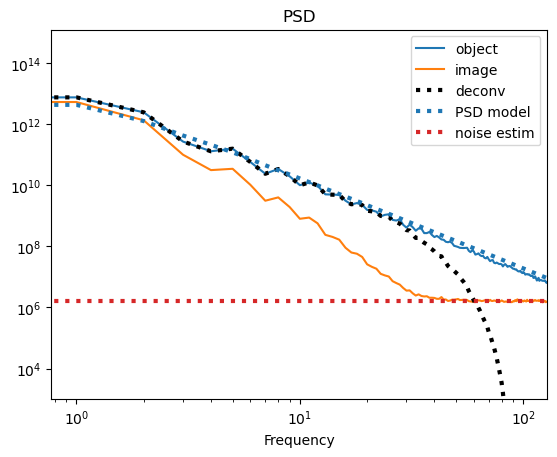

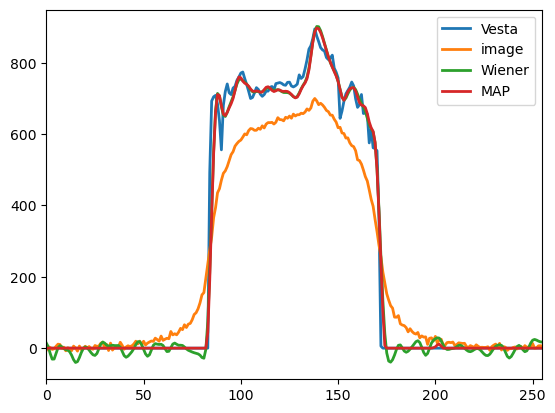

In [50]:
plt.figure(2, figsize=(15,5))
plt.clf()
plt.subplot(121)
plt.title('Wiener deconvolution')
plt.imshow(deconv_wiener, cmap='gray')
plt.colorbar()
plt.subplot(122)
plt.title('MAP deconvolution')
plt.imshow(deconv_map, cmap='gray')
plt.colorbar()

plt.figure(3, figsize=(15,6))
plt.clf()

plt.subplot(121)
plt.title('Wiener')

plt.loglog(circavg(np.abs(vesta_tf)**2), label='object')
plt.loglog(circavg(np.abs(image_tf)**2), label='image')
plt.loglog(circavg(np.abs(deconv_wiener_tf)**2), lw=3, ls=':', c='k', label='deconv')

plt.loglog(circavg(psd_obj), c='C0', lw=3, ls=':', label='PSD model')
plt.loglog(circavg(psd_noise*np.ones((nx,nx))), c='C3', lw=3, ls=':', label='noise estim')

plt.xlabel('Frequency')
plt.legend()
plt.ylim(1e5, 2*flux**2)
plt.xlim(right=nx//2)


plt.subplot(122)
plt.title('MAP')

plt.loglog(circavg(np.abs(vesta_tf)**2), label='object')
plt.loglog(circavg(np.abs(image_tf)**2), label='image')
plt.loglog(circavg(np.abs(fft(deconv_map))**2), lw=3, ls=':', c='k', label='deconv')

plt.xlabel('Frequency')
plt.legend()
plt.ylim(1e5, 2*flux**2)
plt.xlim(right=nx//2)



plt.figure(4)
plt.clf()
plt.plot(np.mean(vesta[nx//2-1:nx//2+2,:], axis=0), lw=2, label='Vesta')
plt.plot(image[nx//2,:], lw=2, label='image')
plt.plot(deconv_wiener[nx//2,:], lw=2, label='Wiener')
plt.plot(deconv_map[nx//2,:], lw=2, label='MAP')
plt.legend()
plt.xlim(0,nx-1)

### Tasks After Running This Tutorial:

If you still have some time and would like to explore more about deconvolution, you can use this notebook to investigate the following tasks by adjusting some inputs:

1. **Impact of S/N on Deconvolution**:
   - How does the signal-to-noise ratio (S/N) affect the deconvolution result?
   Try reducing the flux to lower the S/N and observe how the result changes.
   
2. **Impact of PSF Accuracy on Deconvolution**:
   - How does the accuracy of the Point Spread Function (PSF) influence the deconvolution result?
   Several PSFs are provided in the folder. Try using a different PSF than the one used to create the image and compare the results. 